# Evidence 2 - Unsupervised learning

Paulina Leal Mosqueda, A01659576

Santiago Nava Figueroa, A01174557

Natalie Wilske, A01764862

In [1]:
import sys

assert sys.version_info >= (3, 7)
import pandas as pd

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
import openml
import pandas as pd

# Get Dataset from OPENML
dataset = openml.datasets.get_dataset(23)


df, *_ = dataset.get_data()

# Get features as X
X = df.drop('Contraceptive_method_used',axis=1)

# Get class as y
y = df['Contraceptive_method_used']

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Wifes_age                     1473 non-null   uint8   
 1   Wifes_education               1473 non-null   category
 2   Husbands_education            1473 non-null   category
 3   Number_of_children_ever_born  1473 non-null   uint8   
 4   Wifes_religion                1473 non-null   category
 5   Wifes_now_working%3F          1473 non-null   category
 6   Husbands_occupation           1473 non-null   category
 7   Standard-of-living_index      1473 non-null   category
 8   Media_exposure                1473 non-null   category
dtypes: category(7), uint8(2)
memory usage: 14.2 KB


In [5]:
X.describe()

,Wifes_age,Number_of_children_ever_born
count,1473.000000,1473.000000
mean,32.538357,3.261371
std,8.227245,2.358549
min,16.000000,0.000000
25%,26.000000,1.000000
50%,32.000000,3.000000
75%,39.000000,4.000000
max,49.000000,16.000000


# Preprocessing

The numerical features will be scaled because the variables of the wife's age and number of children ever born have different magnitudes. Therefore, the distances that k-means calculates will be affected by this, and there will be some bias towards some points. Moreover, all categorical variables will be treated with OneHotEncoder, as the page OpenMl states.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder


# Convert all categorical with One Hot Encoder
categorical_features = ["Wifes_education", 'Husbands_occupation', "Husbands_education", "Standard-of-living_index"]
numeric_features = ["Wifes_age", "Number_of_children_ever_born"]  
binary_features = ["Wifes_religion", "Wifes_now_working%3F", "Media_exposure"]


# Create pipline for categorical vairables (OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Scale numeric variables
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

#OrdinalEncoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

#Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features), #remain unchanged
        ('num', numeric_transformer, numeric_features),
    ]
)

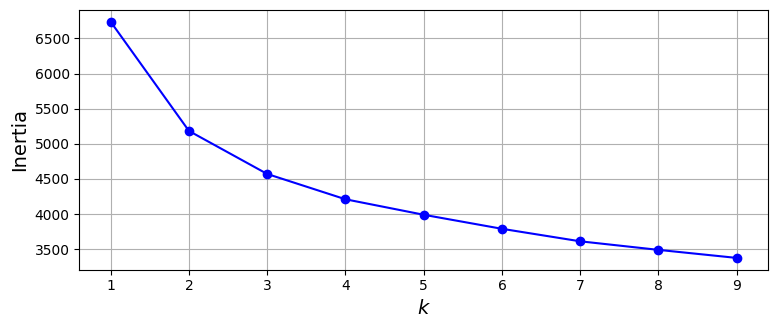

In [7]:
from sklearn.cluster import KMeans

X = preprocessor.fit_transform(X)

kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.grid()
save_fig("inertia_vs_k_plot")
plt.show()

The graph doesn't show a sharp elbow, although the value of k starts to drop more when it's equal to 2 and 3. After this, the inertia begins to go down until it flattens more. Thus, the inflexion point is around k = 2 or k = 3.

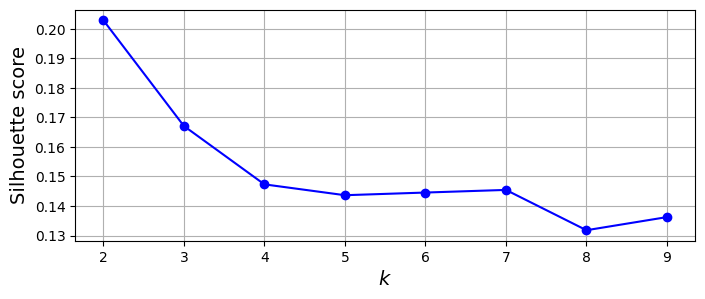

In [8]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]



plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid()
plt.show()

The highest point for the silhouette metric is k = 2, which confirms what the inertia graph showed. This means that the clustering is better when k = 2. 

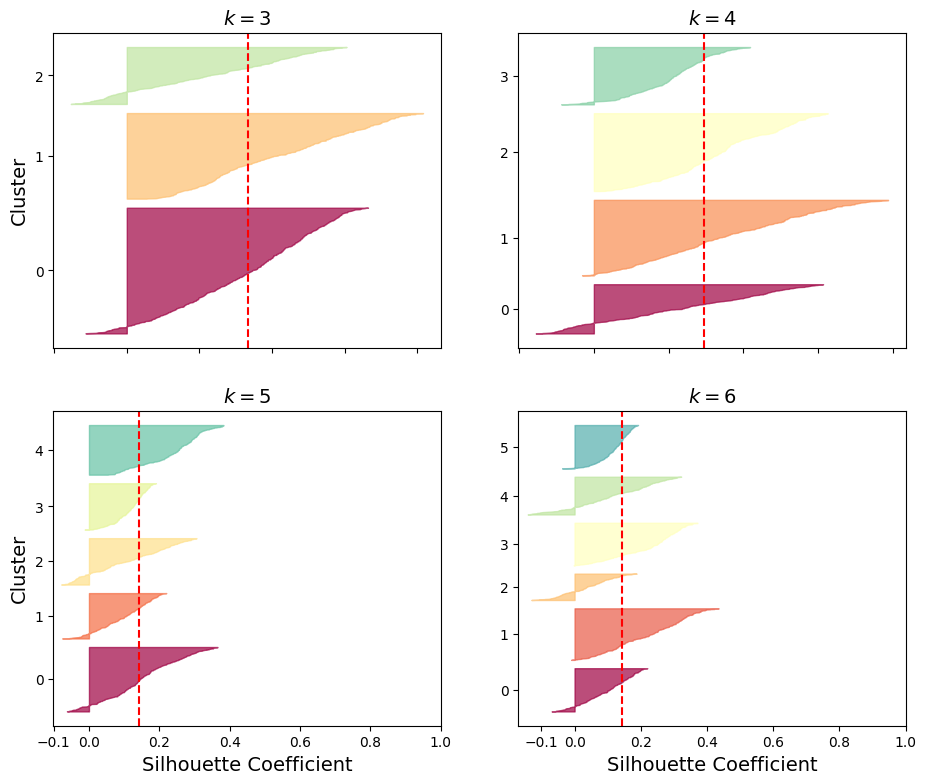

In [9]:
import numpy as np

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")


plt.show()

To verify that k > 2, is not an option we made these graphs where we can observe that even though all of the clusters go above the average clustering score, the groups are unbalanced. For k = 3, we can observe how the third cluster is being recognized, but hardly, since its size is small. With k = 4, we can see that the clusters are a bit more balanced. Nevertheless, the third cluster is closer to the dashed line, meaning that it doesn't have a high silhouette score. Meanwhile, for k = 5 and k = 6, the clusters become smaller and closer to the mean, which suggests that the clusters have low silhouette scores. However, since the graph before showed that k = 2, has a better score, we will plot this individually and observe if it gets better results.

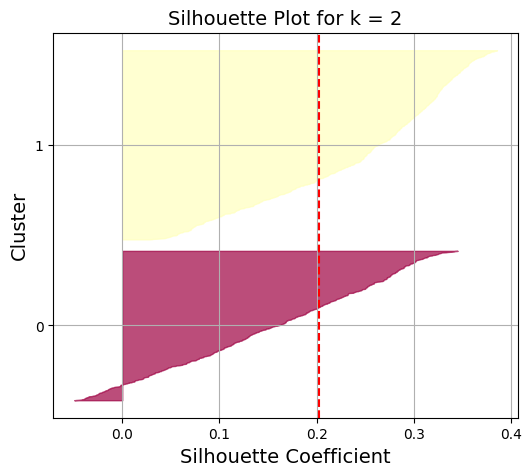

In [10]:
k = 2
plt.figure(figsize=(6, 5))
y_pred = kmeans_per_k[k - 1].labels_
silhouette_coefficients = silhouette_samples(X, y_pred)

padding = len(X) // 30
pos = padding
ticks = []
for i in range(k):
    coeffs = silhouette_coefficients[y_pred == i]
    coeffs.sort()
    color = plt.cm.Spectral(i / k)
    plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ticks.append(pos + len(coeffs) // 2)
    pos += len(coeffs) + padding

plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
plt.axvline(x=silhouette_scores[0], color="red", linestyle="--")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette Plot for k = 2")
plt.grid()
plt.show()


The graph shows two clusters that go above the average silhouette score and, they have a more similar size. The clusters remain unbalanced, indicating that the model isn't clustering correctly, even with the highest score of k = 2. However, as seen before, adding more clusters lowered the silhouette score and produced smaller groups. Hence, the best k-value for this dataset is two.


# Interpretation

In [24]:
import numpy as np

kmean_k= KMeans(n_clusters=2, random_state=42, n_init=10)
final_clusters = kmean_k.fit_predict(X)

cluster_sizes = np.bincount(final_clusters)
print(f"Cluster sizes: {cluster_sizes}")

silhouette_avg = silhouette_score(X, final_clusters)
print(f"\nAverage Silhouette Score: {silhouette_avg:.3f}")

Cluster sizes: [650 823]

Average Silhouette Score: 0.203


The data is split into two clusters of similar size, which means that there is a low level of imbalance and that the groups have slightly the same size. The 0.203 score indicates a low silhouette score, suggesting weak cluster separation and potential overlap between groups. To verify this, we will do a PCA visualization to check if there is an overlap.

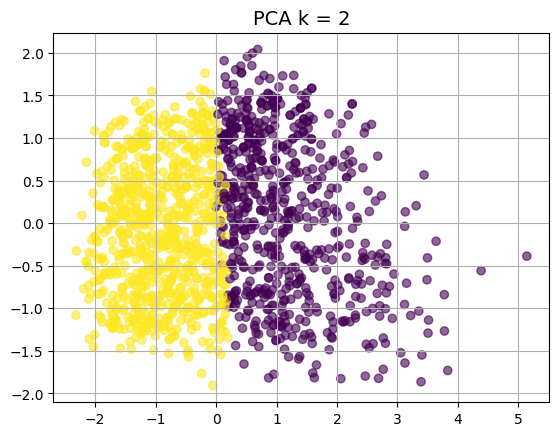

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_reduced = PCA(n_components=2).fit_transform(X)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_per_k[1].labels_, alpha=0.6)
plt.title("PCA k = 2")
plt.grid(True)
plt.show()


As we can see, the model is clustering both groups correctly, and there is no overlap. Therefore, the low silhouette score indicates that not all features contribute meaningfully to the clustering. Despite this, k=2 is still the best score compared to the others and with the PCA visualization, we can confirm that the groups are being separated adequately.

In [13]:
df['cluster'] = kmeans_per_k[1].labels_
df.groupby('cluster')[numeric_features].describe()

Wifes_age                                                     \
            count       mean       std   min   25%   50%   75%   max   
cluster                                                                
0           650.0  39.938462  5.268088  28.0  36.0  40.0  44.0  49.0   
1           823.0  26.693803  4.668687  16.0  23.0  26.0  30.0  42.0   

        Number_of_children_ever_born                                          \
                               count      mean       std  min  25%  50%  75%   
cluster                                                                        
0                              650.0  4.940000  2.370420  0.0  3.0  5.0  6.0   
1                              823.0  1.935601  1.239843  0.0  1.0  2.0  3.0   

               
          max  
cluster        
0        16.0  
1         6.0

# Descirption of each cluster

Cluster 0 (650 women)
* The mean age of the wife is 39.93 years old. Most women are around 36 - 44.
* The mean of the number of children born is 4.94. Most women have between 3-6 children.
* The maximum amount of children born is 16.

Cluster 1 (823)
* The mean age of the wives is 26.69, and they tend to be around 23-30. 
* The mean of the number of children born is 1.93. Most women have between 1-3 children. 
* The maximum amount of children born is 6.

By analysing only the numerical features, we can observe that cluster 0 might represent the group of older women, while cluster 1 represents the younger wives. In this case, it is possible to see that when women are older they tend to have more kids than when they are younger. Therefore, there might be a generational difference, that causes older women to have more kids than younger ones.

# Analysis for categorical and binary features

In [14]:
features = [
    "Wifes_education", 
    "Husbands_occupation", 
    "Husbands_education", 
    "Standard-of-living_index", 
]

for col in features:
    print(f"\n-----{col} -----")
    print(pd.crosstab(df["cluster"], df[col], normalize="index").round(3))


-----Wifes_education -----
Wifes_education      1      2      3      4
cluster                                    
0                0.158  0.211  0.238  0.392
1                0.060  0.239  0.310  0.391

-----Husbands_occupation -----
Husbands_occupation      1      2      3      4
cluster                                        
0                    0.357  0.314  0.320  0.009
1                    0.248  0.269  0.458  0.026

-----Husbands_education -----
Husbands_education      1      2      3      4
cluster                                       
0                   0.046  0.138  0.234  0.582
1                   0.017  0.107  0.243  0.633

-----Standard-of-living_index -----
Standard-of-living_index      1      2      3      4
cluster                                             
0                         0.063  0.138  0.260  0.538
1                         0.107  0.169  0.318  0.406


**Wife's education**

Cluster 0:
* 15% of low education.

Cluster 1:
* 6% of low education.

Overall, the level of education is similar, but cluster 1 has fewer women with low educational levels.

**Husband's occupation**

Cluster 0:
* Higher proportion for occupations 1 and 3.
* Just 0.9% have occupation 4.
* The distribution is similar.

Cluster 1:
* 45% have occupation 2.

While cluster 0 suggests a mixture of occupations, most of the husbands in cluster 1 work in occupation 4.

**Husbands education**

Cluster 0:
* The majority of the husbands have a higher level of education.

Cluster 1:
* The majority of the husbands have a higher level of education.

Both clusters prioritize higher education, but Cluster 0 has slightly more results in levels 2 and 3.


**Standard-of-living_index**

Cluster 0:
* 53% have high living standards

Cluster 1:
* 40% have high living standards

In both cases, the living standard tends to be high. However, cluster 0 has more women with higher standards than cluster 1.

In [15]:
features = [
    "Wifes_religion", 
    "Wifes_now_working%3F", 
    "Media_exposure"
]

for col in features:
    print(f"\n-----{col} -----")
    print(pd.crosstab(df["cluster"], df[col], normalize="index").round(3))


-----Wifes_religion -----
Wifes_religion      0      1
cluster                     
0               0.185  0.815
1               0.122  0.878

-----Wifes_now_working%3F -----
Wifes_now_working%3F      0      1
cluster                           
0                     0.242  0.758
1                     0.258  0.742

-----Media_exposure -----
Media_exposure      0      1
cluster                     
0               0.889  0.111
1               0.955  0.045


**Wife's religion**

Cluster 0:
* 81.5% of the women are religious (Islam).

Cluster 1:
* 87.8% of the women are religious (Islam).

Cluster 0, has more non-religious women than cluster 1.

**Wife's now working**

Cluster 0:
* 75% of women work.

Cluster 1:
* 74% of women work.

The distribution is fairly similar for both clusters, which means that working status does not meaningfully separate clusters. 

**Media's exposure**

Cluster 0:
* 88% of women aren't exposed to media.

Cluster 1:
* 95% of women aren't exposed to media.

Both clusters suggest that women have low media exposure in both clusters. 

# Overall insights of clusters

Cluster 0:

* Women have higher age and have more children.
* Most have a high educational level.
* Husband's occupation varies and, they tend to have a high education level.
* High living standards.
* They are mostly religious.
* The vast majority work.
* Low media exposure.


Cluster 1:

* Women are younger and have fewer children.
* Most have a high educational level.
* Husbands tend to have occupation 3 and they have a high education level.
* High living standards, although cluster 0 has better results.
* They are mostly religious.
* The majority of women work.
* Low media exposure.

# Decision Tree

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


df, *_ = dataset.get_data()

# Get features as X
X_new = df.drop('Contraceptive_method_used',axis=1)

# Get class as y
y_new = df['Contraceptive_method_used']


x_clusters = X_new.copy()
x_clusters["cluster"] = final_clusters


X_tree = x_clusters.drop(columns="cluster")
y_tree = x_clusters["cluster"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tree, y_tree, stratify=y_tree, random_state=42)

# Pipline for decision tree
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])


tree_pipeline.fit(X_train, y_train)

y_pred = tree_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

best_tree = tree_pipeline.named_steps["classifier"]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       163
           1       0.99      0.99      0.99       206

    accuracy                           0.99       369
   macro avg       0.99      0.99      0.99       369
weighted avg       0.99      0.99      0.99       369



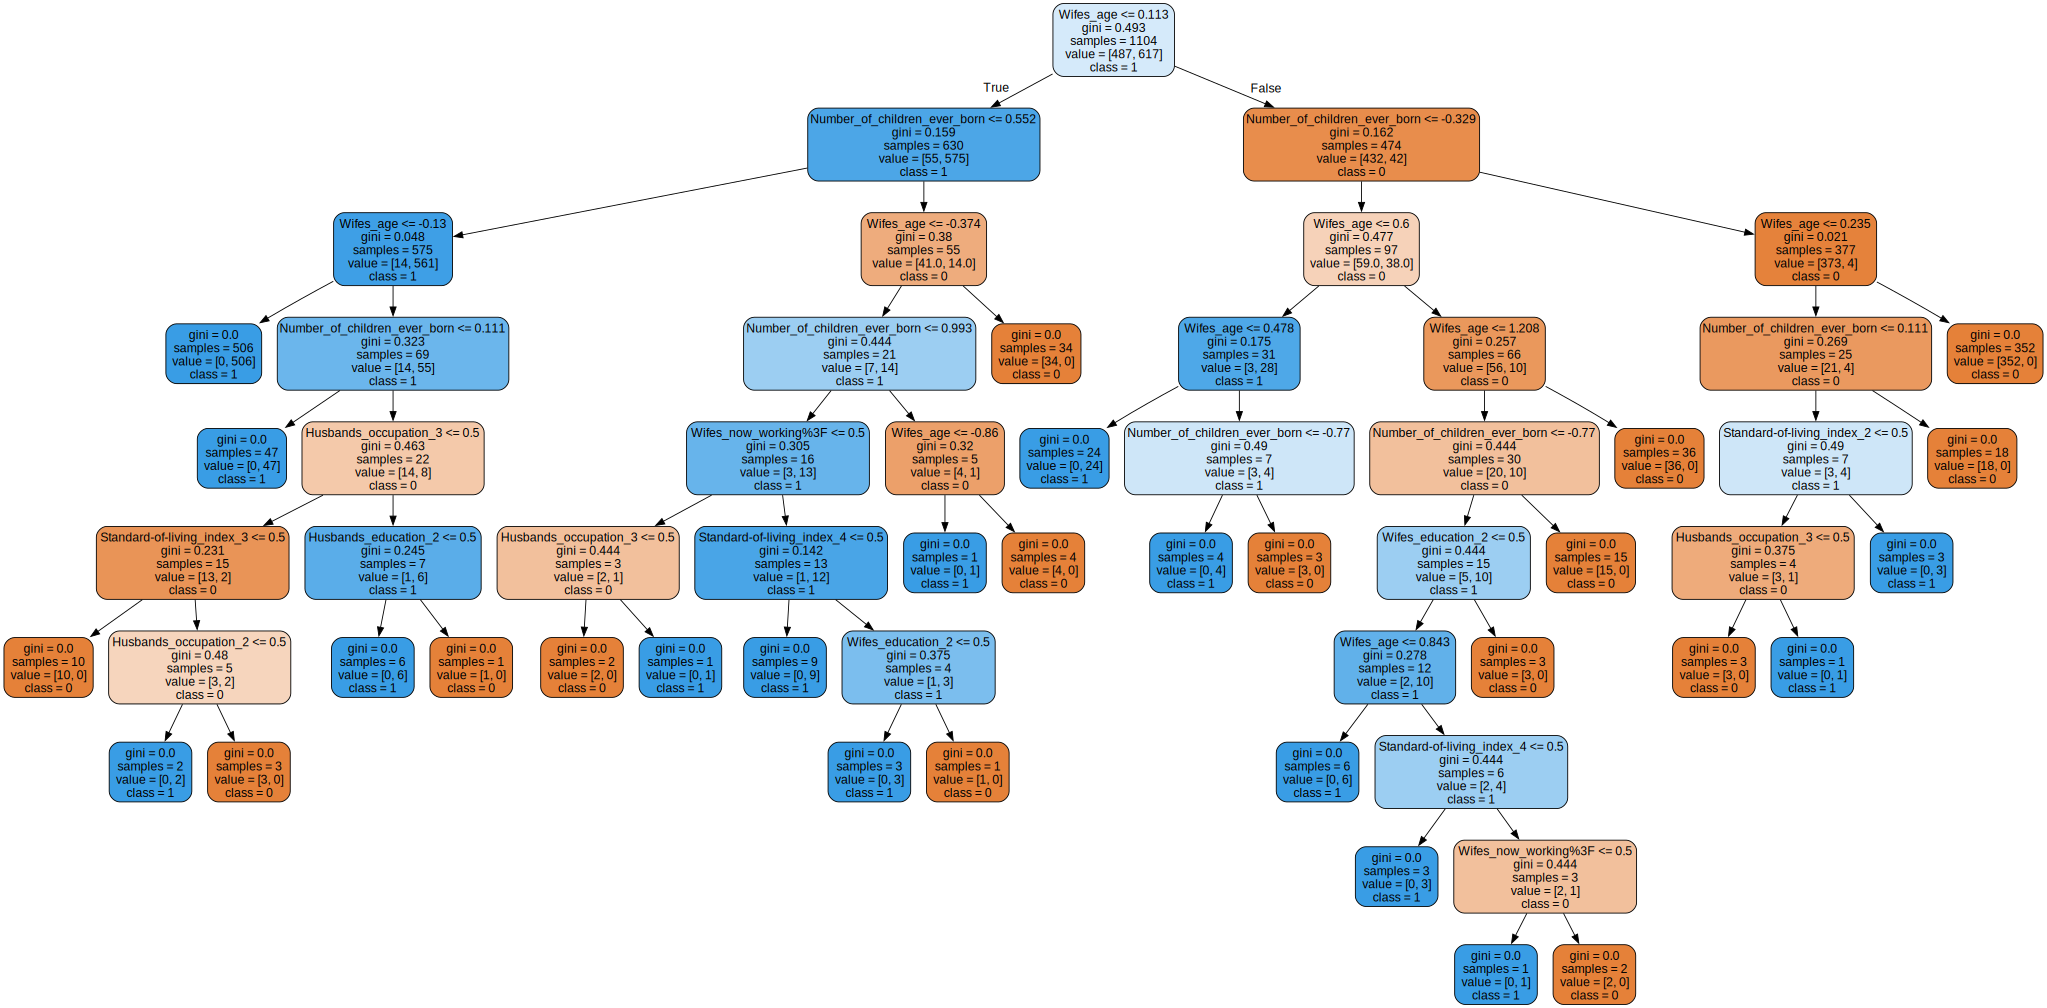

In [18]:
from sklearn.tree import export_graphviz
from graphviz import Source


raw_feature_names = tree_pipeline.named_steps['preprocessor'].get_feature_names_out()

clean_feature_names = [name.split("__")[-1] for name in raw_feature_names]


export_graphviz(
    best_tree,
    out_file=str(IMAGES_PATH / "best_tree.dot"),
    feature_names=clean_feature_names,
    class_names=["0","1"],
    rounded=True,
    filled=True
)


Source.from_file(IMAGES_PATH / "best_tree.dot")

# Interpretation

The decision tree can distinguish both clusters with scores higher or equal to 98%.

The tree begins by splitting the nodes from the feature of the wife's age and it then creates two nodes that lead to several others.

Class 0 (486):

* It's classified mostly when the wife's age is greater than 0.113 at the beginning, although there are some times that even when the age is smaller, they get classified.
* More children ever born
* Husbands with certain occupations (Occupation_3 appears significant)
* Higher standard of living (level 3 and 4 appear)
* Wives that are not currently working tend to appear more here.

Class 1 (617):

* Younger wives
* Less number of children ever born
* Wife's education matters (education level 2)
* Wife's current work affects some predictions
* Relation with husband's occupation 2.


Therefore, the tree shows how younger wives who have fewer children are assigned to class 1, while the majority of older women fall into class 0. In addition to this, the fact that there are more women in class 1, suggests that it is slightly more common to identify women with fewer kids that are younger.



# Comparing clusters with the class.

Cluster 0/Class 0:
Older wives tend to have more children, and they often have a high standard of living (3 and 4). The cluster results suggest most women worked, but the decision tree identified distinct groups of non-working women, highlighting the difference between them. The decision tree confirms that cluster 0 contains wives who are older and who have more children.

Cluster 1/Class 1:
Both results show how younger women have fewer children. The tree suggests husband's occupation 3 can be an indicator of being part of class 3. Even if the clustering results showed how most wives work, the decision tree identifies the importance of having a level of education of 2 to be able to work. Thus, the decision tree results confirm what the statistics of the clusters indicated.


# Understanding unique characteristics for the clusters
The clusters highlight two different results that help to understand some insights about the characteristics of women in India and the relation that it has with their demographic and socio-economic situation. Initially, older women tend to have more children (cluster 0), while younger women have fewer and often husbands in occupation 3, though the dataset lacks details about this occupation. It was interesting to see that women with more kids often have a high living standard, which contradicts the common belief that this is typical for those with fewer children. Meanwhile, given the distribution of the other features, there were no more unique characteristics for the clusters.

Although the silhouette score was low initially, this is likely because not all features were relevant during the clustering process. This can be confirmed with the decision tree results, where the features of media exposure and the wife's religion, were not included in the splits. Furthermore, the statistical results from the clustering, also allow us to see this, because the results for both clusters were similar in those features. Therefore, the model provides insights about the dataset, but the low silhouette score indicates that not all features contributed to the clustering.


# Conclusion
The clustering model achieved a silhouette score of 0.203 while identifying two different demographic profiles. Cluster 0 represented the older women with more children and who interestingly had higher living standards. Cluster 1 represented the younger women with fewer children and husbands with occupation 3. With the decision tree model, it was possible to validate the results of the clusters while having scores that were greater or equal to 98% for all measures. Despite a low silhouette score indicating some features with low relevance, the model identified key characteristics that provide insights about women in India and their fertility rate.
